# DSCI 100 Group Project Report (Group 17)
## Factors of Toxicity of Mushrooms (Chosen Data Set: Mushrooms)

In [16]:
library(tidyverse)
library(tidymodels)
library(cowplot)

Warning message:
“package ‘cowplot’ was built under R version 4.0.3”


In [4]:
set.seed(87)
data <- read_csv("https://raw.githubusercontent.com/alexcw-5/DSCI-100-Group-Project/master/mushrooms.csv")
# to make the column names usable with ggplot and other commands, hyphens do not work
colnames(data) <- make.names(colnames(data))
filtered <- data %>% select(cap.color, gill.color, ring.type, class)
split <- initial_split(filtered, prop = 0.75, Strata = class)
train <- training(split)
test <- testing(split)
# plot <- ggplot(data, aes(x=cap.color)) +
#         geom_histogram(binwidth=1)
# plot

Parsed with column specification:
cols(
  .default = col_character(),
  bruises = col_logical(),
  `gill-attachment` = col_logical()
)

See spec(...) for full column specifications.

Warning message:
“210 parsing failures.
 row             col           expected actual                                                                                     file
6039 gill-attachment 1/0/T/F/TRUE/FALSE      a 'https://raw.githubusercontent.com/alexcw-5/DSCI-100-Group-Project/master/mushrooms.csv'
6041 gill-attachment 1/0/T/F/TRUE/FALSE      a 'https://raw.githubusercontent.com/alexcw-5/DSCI-100-Group-Project/master/mushrooms.csv'
6376 gill-attachment 1/0/T/F/TRUE/FALSE      a 'https://raw.githubusercontent.com/alexcw-5/DSCI-100-Group-Project/master/mushrooms.csv'
6425 gill-attachment 1/0/T/F/TRUE/FALSE      a 'https://raw.githubusercontent.com/alexcw-5/DSCI-100-Group-Project/master/mushrooms.csv'
6435 gill-attachment 1/0/T/F/TRUE/FALSE      a 'https://raw.githubusercontent.com/alexcw-5/DSCI-1

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”
Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”
Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”


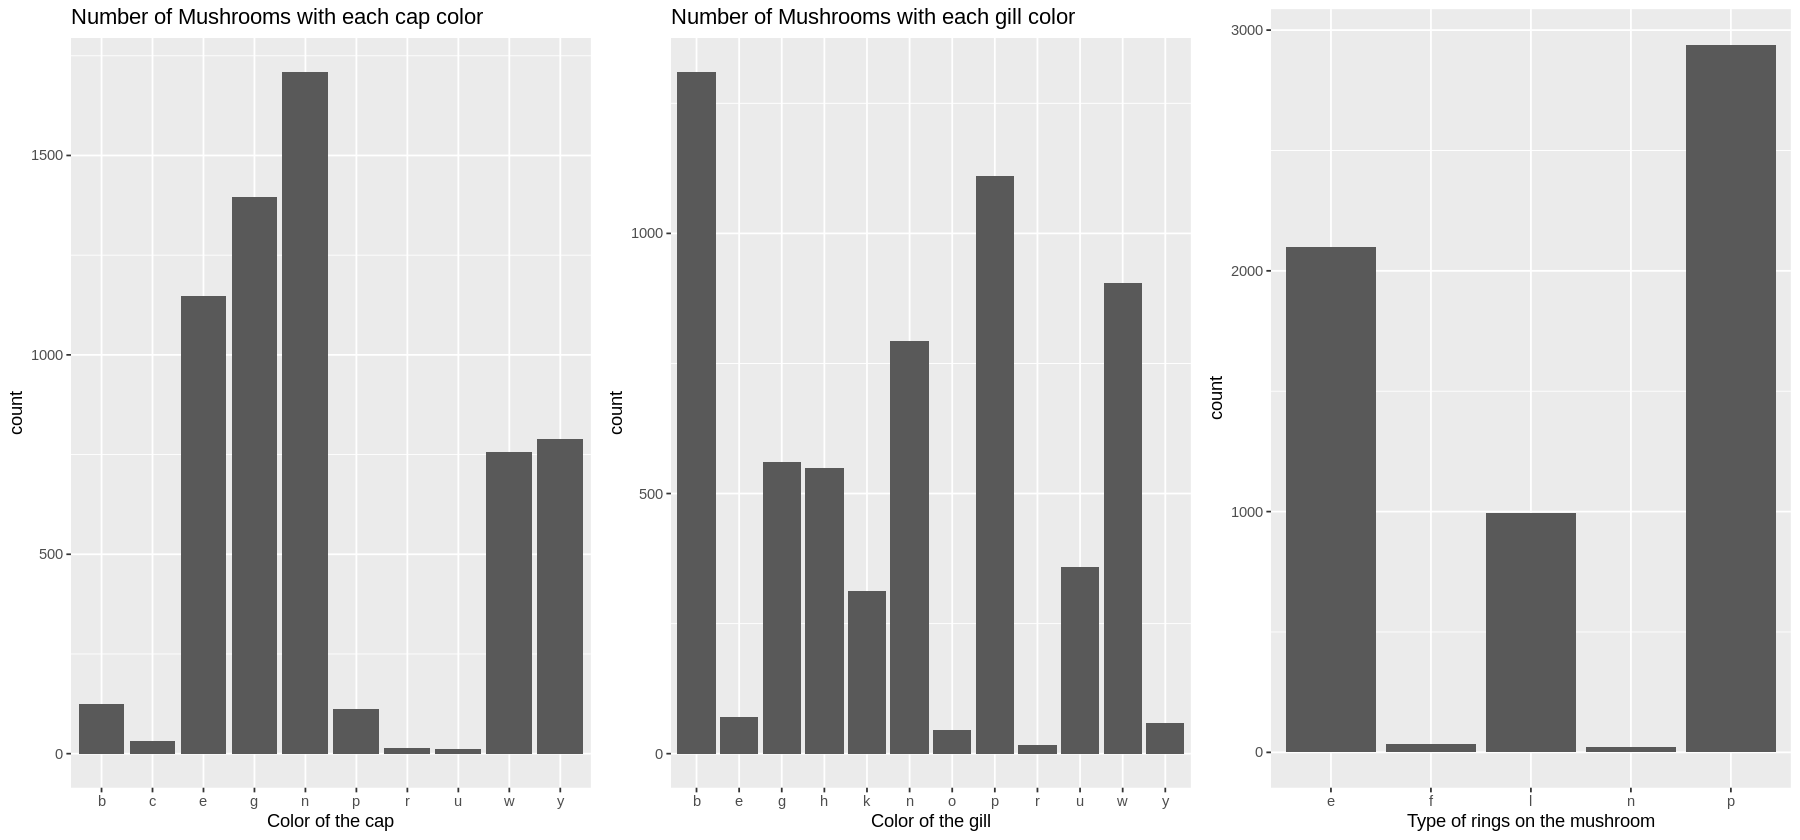

In [17]:
cap_color <- train %>% ggplot(aes(x=cap.color)) + geom_histogram(stat="count") +  labs(x="Color of the cap") + ggtitle("Number of Mushrooms with each cap color")
gill_color <- train %>% ggplot(aes(x=gill.color)) + geom_histogram(stat="count") +  labs(x="Color of the gill") + ggtitle("Number of Mushrooms with each gill color")
ring_type <- train %>% ggplot(aes(x=ring.type)) + geom_histogram(stat="count") + labs(x="Type of rings on the mushroom")
options(repr.plot.width = 15, repr.plot.height = 7)
plot_grid(cap_color, gill_color, ring_type, ncol=3)

### Introduction

#### Background Information

From August through to November, mushrooms are a common sight to see in Canada. Be it deep in the forests of Quebec, or right in the backyard of your home in BC, mushrooms can be found everywhere. But although some may appear to be harmless, upon ingestion, many types of mushrooms may prove to cause various harmful symptoms to the human body. As a result, classification of mushrooms into either edible or poisonous is an extremely significant step for mushroom foragers around the globe. Using multivariable K- Nearest Neighbors classification of the dataset, our goal is to answer the following predictive question: What factors are good predictors of mushroom edibility? KNN classification is suitable for this problem because we desire to form a classifier using multiple characteristics of the mushrooms with a known class to predict if mushrooms without a class are either edible or poisonous for consumption.

### Methodology

Our project goal is to build a predictive model, using the K-Nearest Neighbors Classification algorithm, to determine if a mushroom is edible or poisonous. To do so, we used {insert attributes here} to compute the distance between unseen data points and the K-closest data points. Once we have identified the closest neighbors, we can assign the label that appears the most often in the set of K neighbors to the unseen data point. This algorithm is appropriate for our question because often, mushrooms with similar attributes can be similarly classified as either edible or poisonous. 

We chose to drop some of the attributes from the data set because some of them are very similar to each other, and we wanted to lower the computational time and reduce unnecessary complexity of the algorithm. 

For the initial split of our dataset, we split our data so that 75% was in the training set and 25% was in the testing set. We intuitively chose this because we felt that it was a good ratio in which the model would not be underfit or overfit, while still leaving enough data remaining to use when testing our model. Additionally, it was mentioned in textbook section 6.5.1 that generally, the amount of data that goes in the training set is between 50% and  95%, so as a result, we felt that 75% was a good midpoint between these values. 


### Results

text here

### Discussion

text here

***
## Appendix

#### Bibliography

* text here